Modified from [https://github.com/jiwidi/time-series-forecasting-with-python]

In [2]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.10.0


# 📚 Time series analysis and transforms

This notebook contains a set of operations we can perform in our time series in order to get some insights or transform the series to make forecasting easier.

Which ones will we touching in this notebook?

* Time series decomposition
  * Level
  * Trend
  * Seasonality
  * Noise

* Stationarity
  * AC and PAC plots
  * Rolling mean and std
  * Dickey-Fuller test

* Making our time series stationary
  * Difference transform
  * Log scale
  * Smoothing
  * Moving average

## Load the dataset and quick preview

In [3]:
air_pollution = pd.read_csv('datasets/air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)
air_pollution.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


In [4]:
air_pollution.describe()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,98.245080,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023,98.245080
std,76.807697,14.163508,11.552997,10.076053,41.373161,0.546072,0.993917,76.807697
min,3.166667,-33.333333,-14.458333,994.041667,1.412500,0.000000,0.000000,3.166667
25%,42.333333,-10.083333,1.541667,1007.916667,5.904167,0.000000,0.000000,42.333333
50%,79.166667,2.041667,13.916667,1016.208333,10.953750,0.000000,0.000000,79.166667
75%,131.166667,15.083333,23.166667,1024.541667,22.235000,0.000000,0.000000,131.166667
max,541.895833,26.208333,32.875000,1043.458333,463.187917,14.166667,17.583333,541.895833


Lets check each feature values

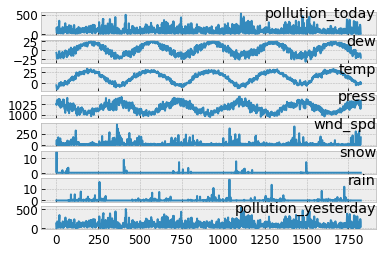

In [5]:
values = air_pollution.values
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(air_pollution.columns[group], y=0.5, loc='right')
    i += 1


plt.show()

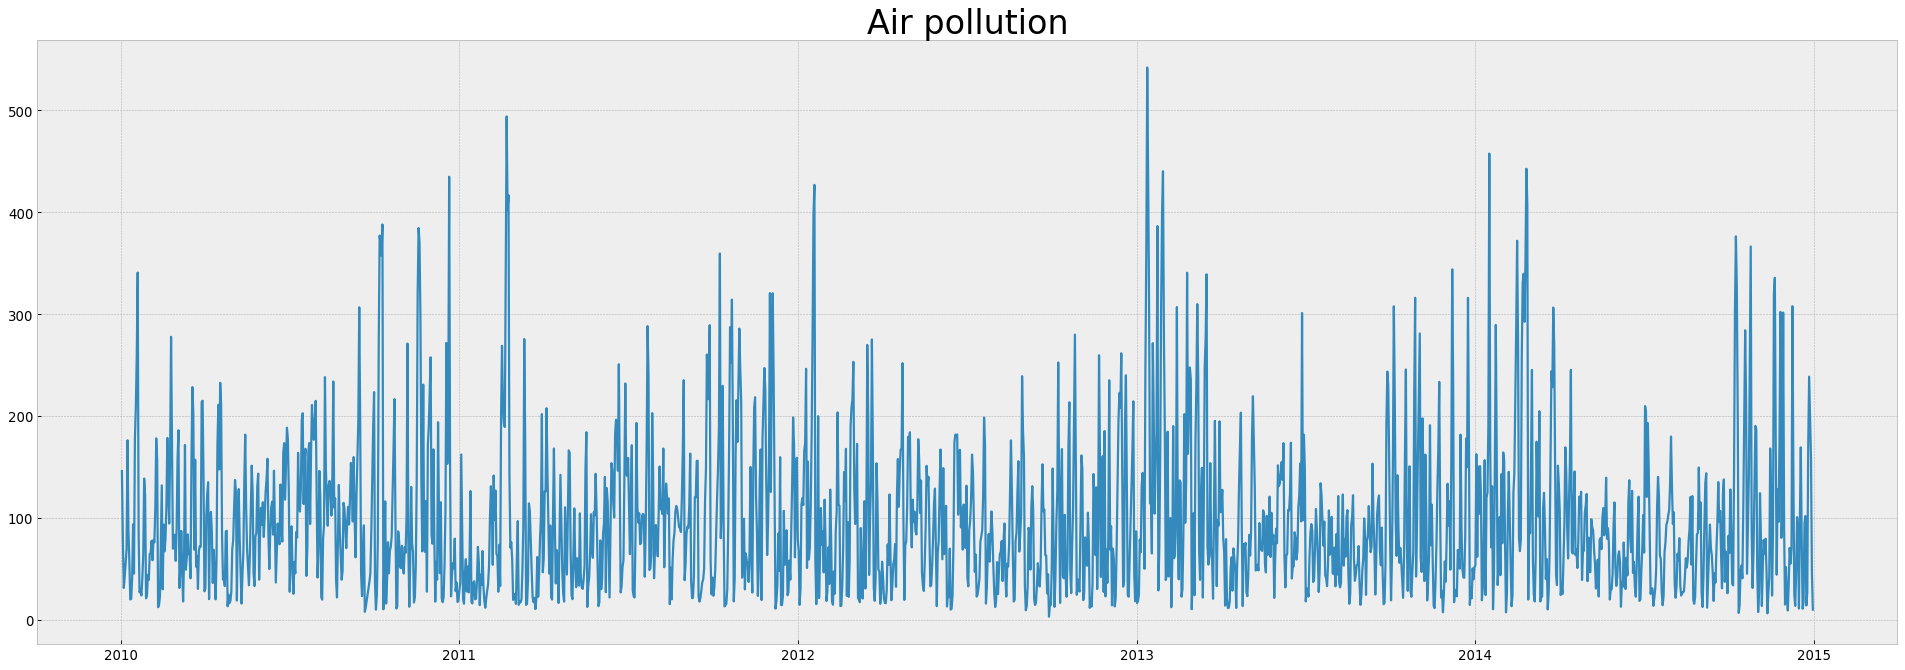

In [6]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Air pollution', fontsize=30)

plt.plot(air_pollution.pollution_today)
plt.savefig("results/pollution.png")

## Decomposing our time series

One of the most common analysis for time series is decomposing it into multiple parts. The parts we can divide a time series into are: level, trend, seasonality and noise, all series contain level and noise but seasonality and trend are not always present (there will be more analysis for this two parts).

This 4 parts can combine either additively or multiplicatively into the time series.

##### Additive Model
`y(t) = Level + Trend + Seasonality + Noise`

Additives models are lineal. Trend is linear and seasonality has constant frequency and amplitude. Change is constant over time

##### Multiplicative model
`y(t) = Level * Trend * Seasonality * Noise`

Multiplicatives models are nonlinear,trend is curved and seasonality is not constant. Change is not constant over time

Decomposing is used to analyse the time series. Identify each one of the different parts of the time series and its behaviour, each of the components may affect your models in different ways.

Most time series are a combination of a additive model and a multiplicate model, is hard to identify real world time series into one single model.

##### Automatic time series decomposition

Statsmodel python library provides a function [seasonal_compose()](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) to automatically decompose a time series, you still need to specify wether the model is additive or multiplicative. We will use multiplicative as our quick peak at the pm2.5 time series shows no linear trend.

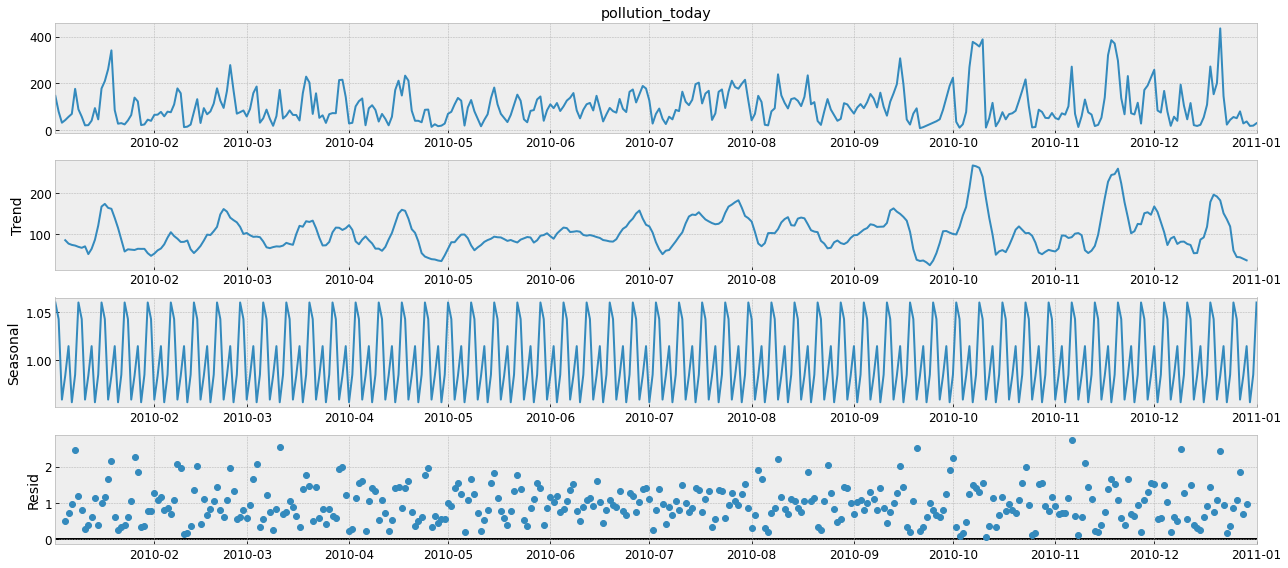

<Figure size 4000x1600 with 0 Axes>

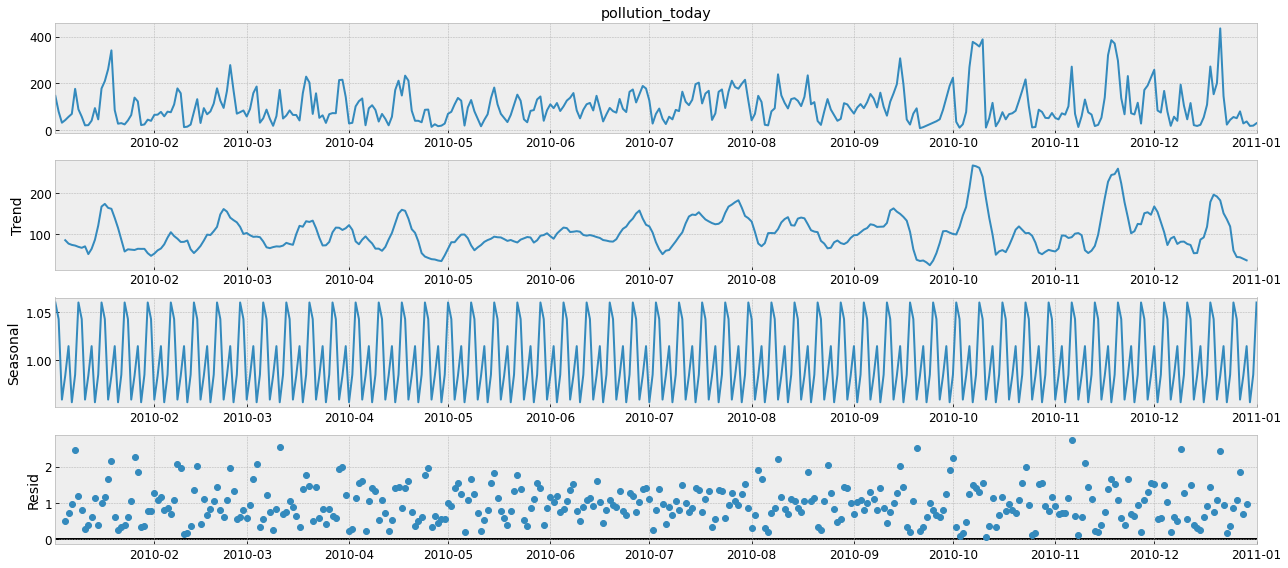

In [7]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

### Level

Level simply means the current value of the series once we remove trend, seasonality and the random noise. This are the true values that come from the series itself and we will try to predict with our models. Most of the models will benefit the more our time series is composed by the level and not trends/seasonality/noise. We also present models capable of handling seasonality and trend (non stationary series)

### Trend

A trend is observed when there is an increasing or decreasing slope observed in the time series. A trend is a smooth, general, long-term, average tendency. It is not always necessary that the increase or decrease is in the same direction throughout the given period of time.

Trend can be removed from your time series data (and data in the future) as a data preparation and cleaning exercise. This is common when using statistical methods for time series forecasting, but does not always improve results when using machine learning models. We will see different methods for this in the making your series stationary section

In practice, identifying a trend in a time series can be a subjective process as we are never sure if contains seasonalities or noise to it,
Create line plots of your data and inspect the plots for obvious trends.

Now we will try some methods to check for trend in our series:
* Automatic decomposing
* Moving average
* Fit a linear regression model to identify trend



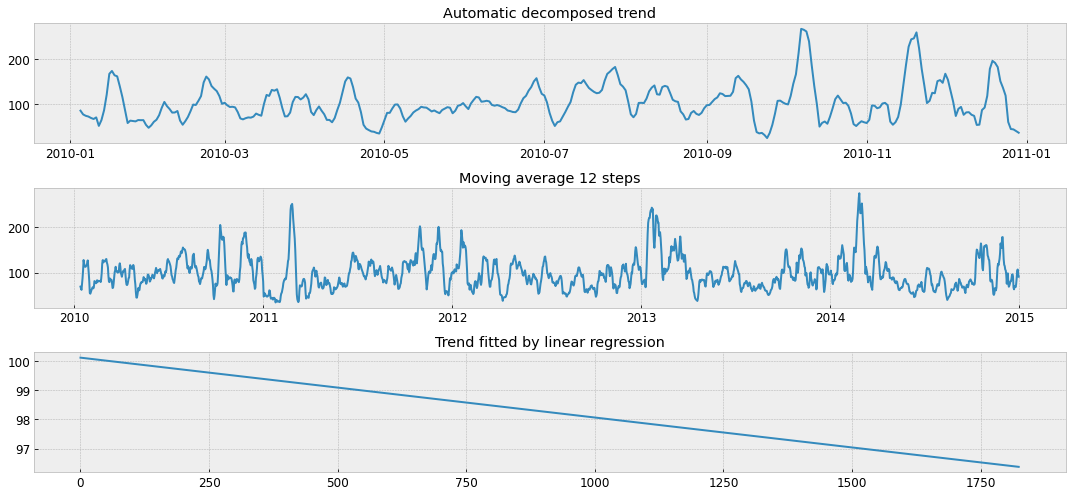

In [8]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = air_pollution.pollution_today.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(air_pollution.pollution_today))]
X = np.reshape(X, (len(X), 1))
y = air_pollution.pollution_today.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

We can see our series does not have a strong trend, results from both the automatic decomposition and the moving average look more like a seasonality efect+random noise than a trend. This sort of confirmed with our linear regression, which cant find our series properly and gives us a poor trend.

We could also try to split our series into smaller ones to try identify subtrends with the mentioned methods but we will not be doing so in this section.

### Seasonality
Seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day. For example the amount of sunscream protector (always low in winter and high in summer).

The automatic decomposing chart did not gave us a good look into the decomposed seasonality, let's try decomposing smaller parts of the time series first and test seasonalities we found into the others.

Lets go with the first year of data only now:

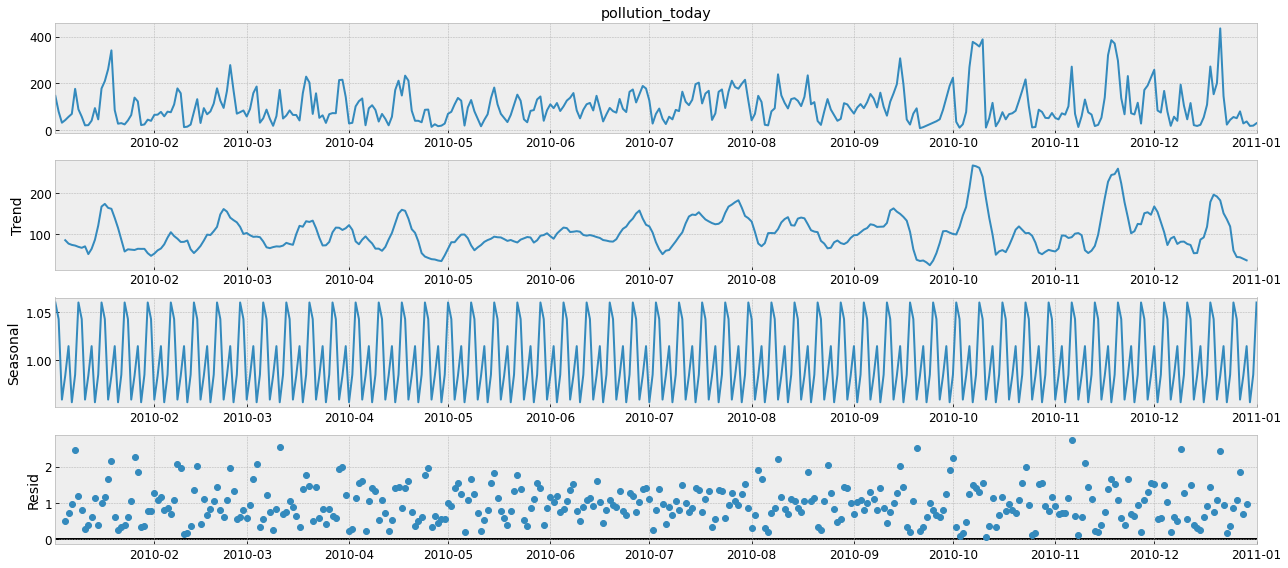

<Figure size 4000x1600 with 0 Axes>

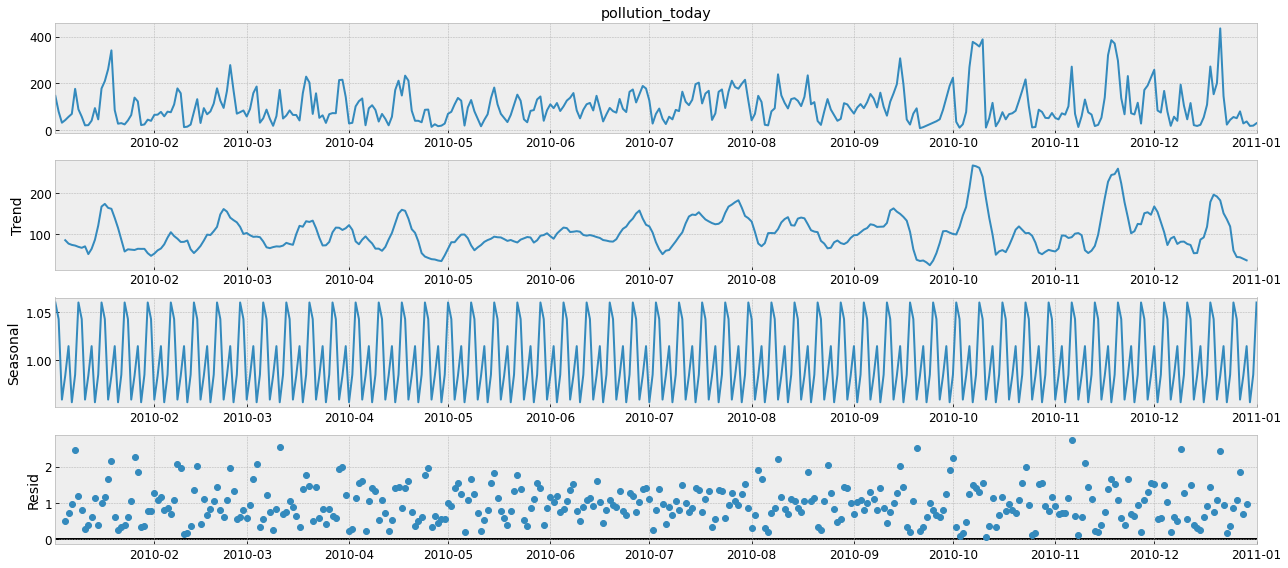

In [9]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

Here can see a clear weekly trend, 4 spikes every month (weerkly). Lets check how the last year of data looks

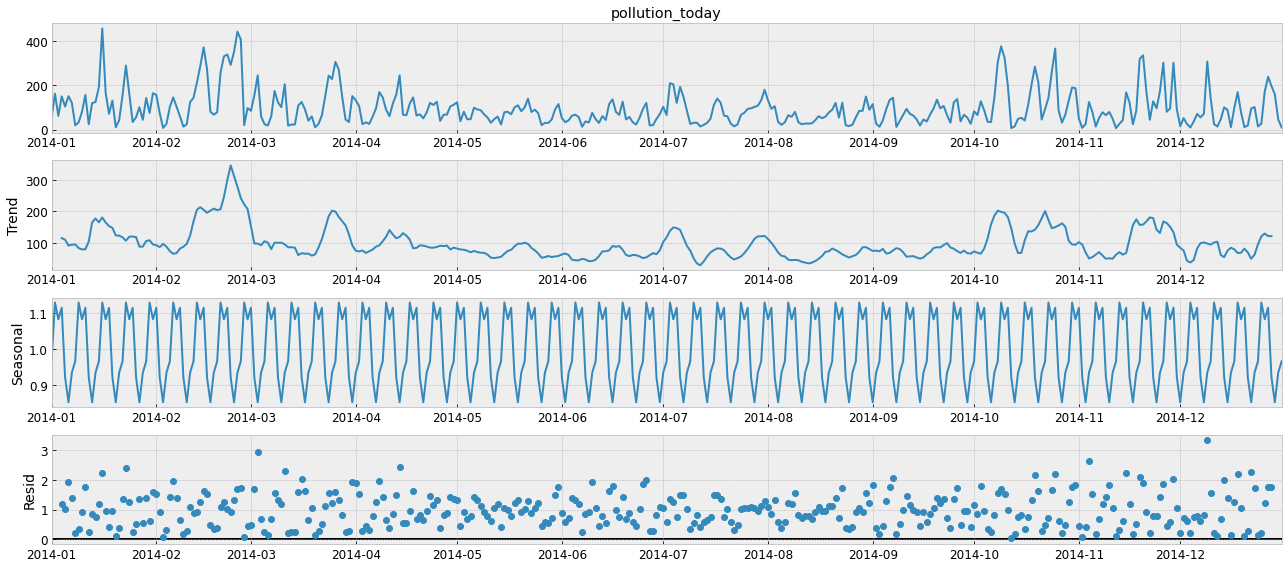

<Figure size 4000x1600 with 0 Axes>

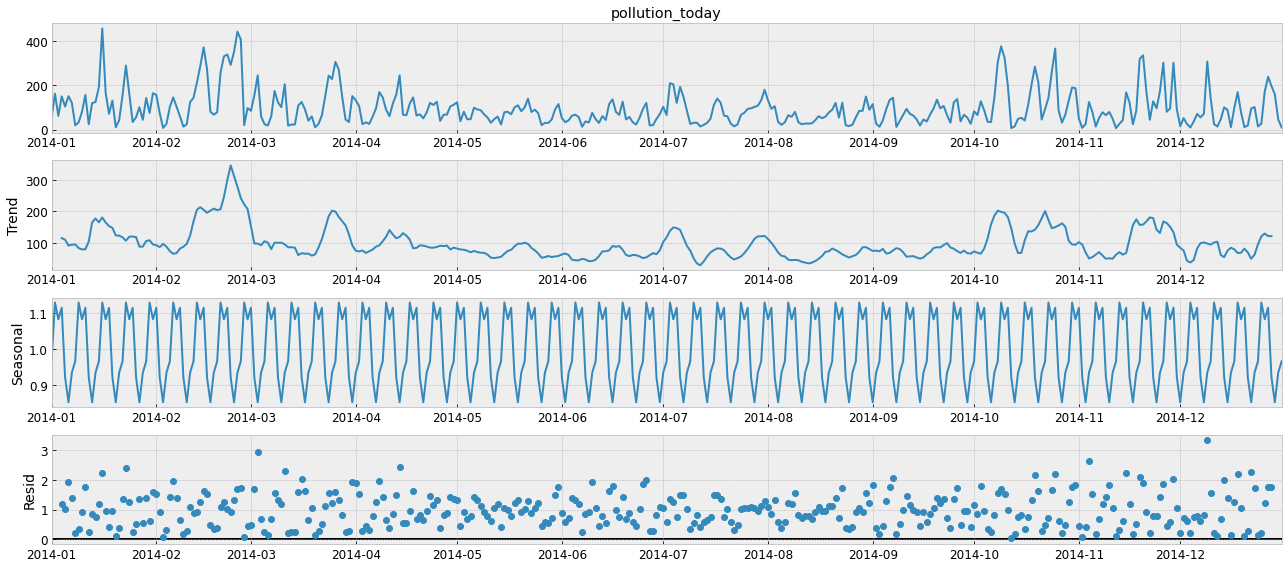

In [10]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[-365:]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

We see another weekly seasonality(4 spikes between every month) but a bit different to the original one, this is something we should always expect from real datasets as their seasonalities will never be perfect but a combination of multiples.

## INTERPRETATION

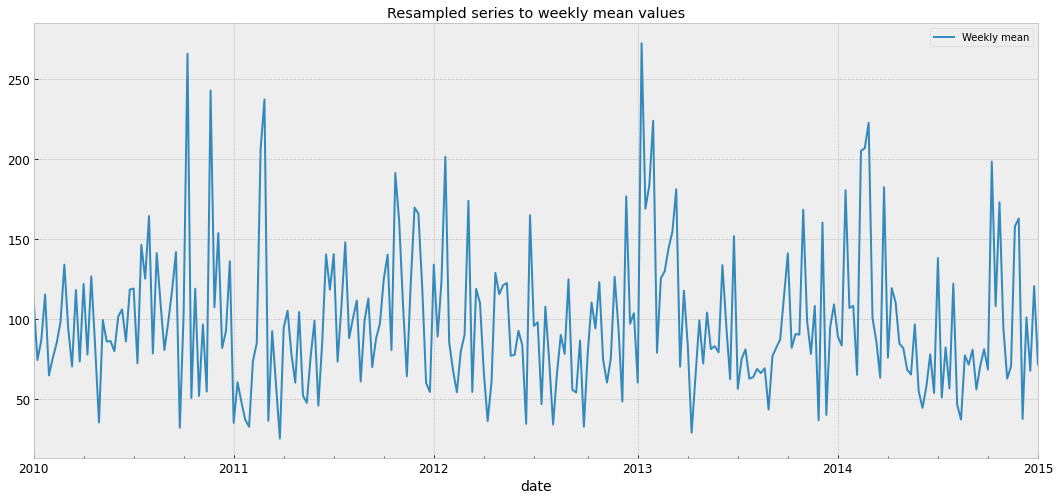

In [12]:
# Looking for weekly seasonality
resample = air_pollution.resample('W')
weekly_mean = resample.mean()
weekly_mean.pollution_today.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

**Manual methods to find seasonalities**

We can also try to generate a model to find the seasonalities for us. One of the most common to use is a simple polynomial model.

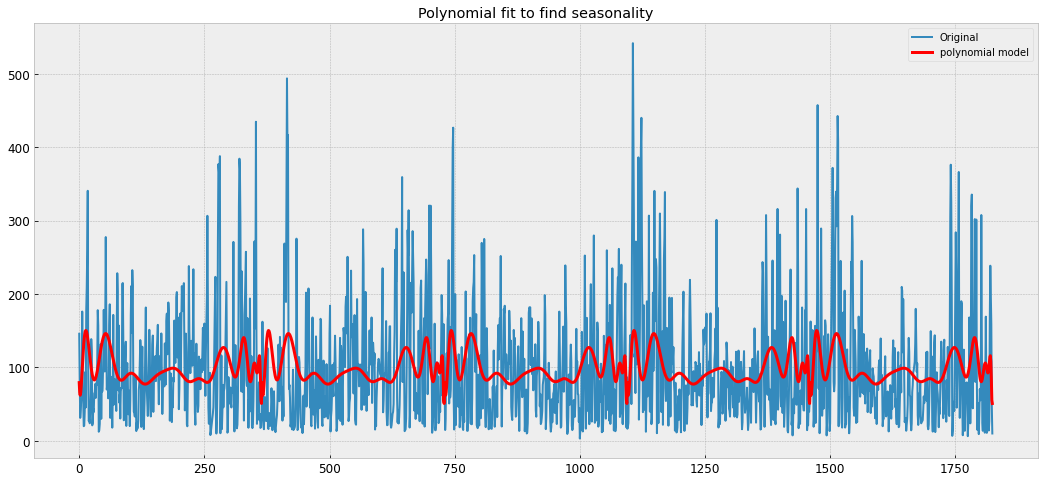

In [11]:
# Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series = air_pollution.pollution_today.values
X = [i % 365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series, label='Original')
plt.plot(curve, color='red', linewidth=3, label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

We can see how the model to find a seasonality fits poorly to our data. Is going to be a complicate time series to model :P

### Noise

Our time series will also have a noise component to them, most likely [white noise](https://en.wikipedia.org/wiki/White_noise). We say white noise is present if the measurement are independent and identically distributed with a mean of zero. This will mean all our measurements have same variance and no correlation with the rest of values in the series.

If our time series has white noise this will mean we can't predict that component of the series (as is random) and we shoul aim to produce a model with errors close to this white noise.

How to check if our series has white noise?
* Check our series histogram, does it look like a Gaussian distribution? Mean=0 and constand std
* Correlation plots
* Standard deviation distribution, is it a Gaussian distribution?
* Does the mean or level change over time?

Text(0.5, 1.0, 'Mean over time')

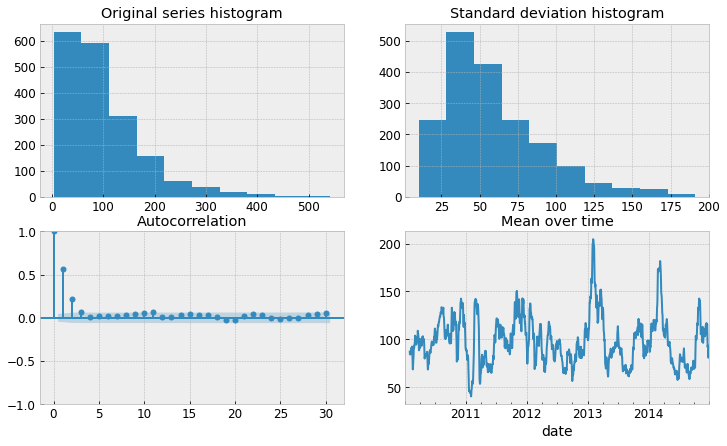

In [13]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

air_pollution.pollution_today.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = air_pollution.pollution_today.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = air_pollution.pollution_today.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")


We can see our series do not follow a Gaussian distribution from the histogram and neither the standard deviation, thought the std does has the mean more centered which shows a small part of white noise that is not possible to split from the original series (this will happen most of the times, specially is real life datasets)).

We also have a small correlation with close measurements in time but not present with distant measurements (this could also indicate low seasonality). The mean over time also shows something similar with a constant value and high peaks in the same moments for the 4 years (smaller in 2012)

We could say our series does contain a small part of white noise but it is really small and hard to remove

## Stationarity
Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.

Often, stock prices are not a stationary process, since we might see a growing trend, or its volatility might increase over time (meaning that variance is changing).

### Check for sationarity




### Autocorrelation and Partial autocorrelation plots

Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n. If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends.

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time.



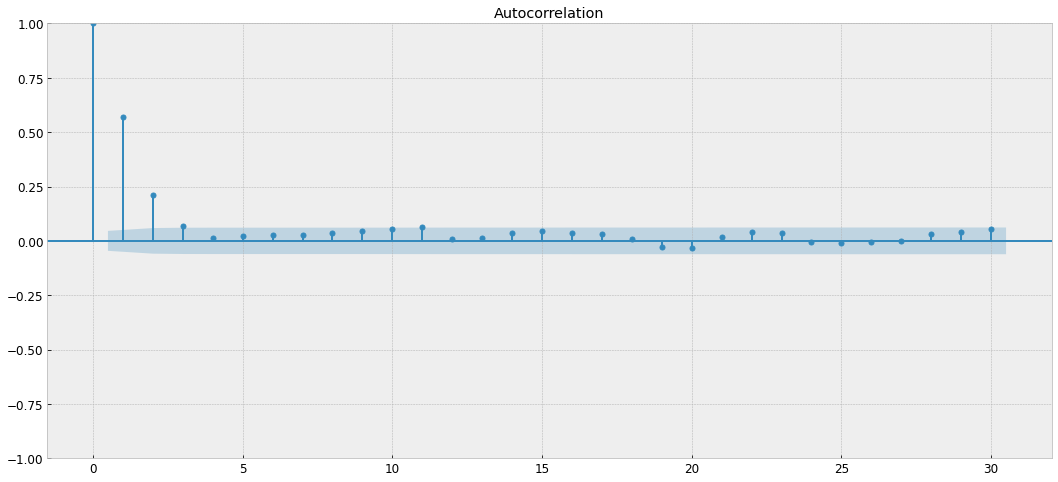

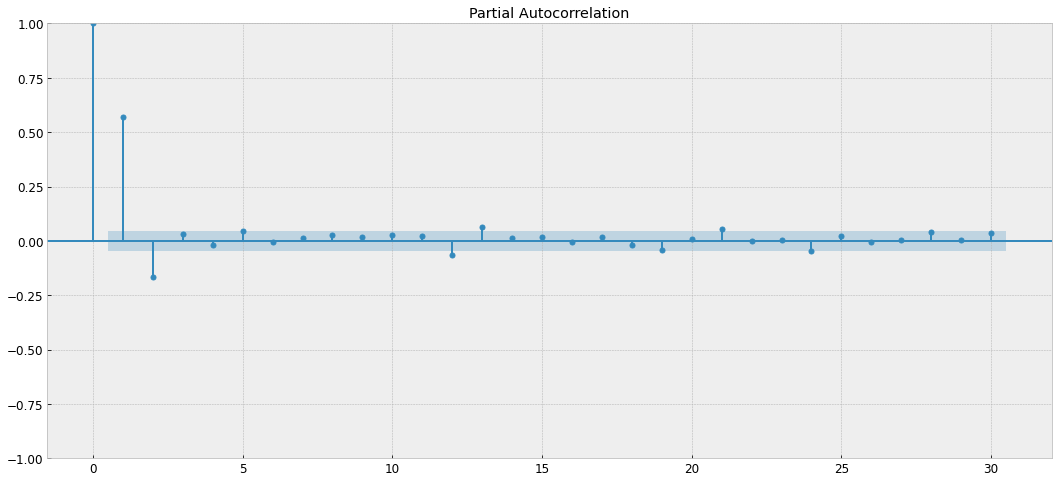

In [14]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

We saw that our time series values are not correlated with distant points in time, this is good and shows us our series should be stationary but for the shake of learning and confirming we will test with some other methods

### Rolling means and standard deviation of our series

We were talking about how our mean and standard deviation should be constant over time in order to have a stationary time series, why not just plot this two properties?

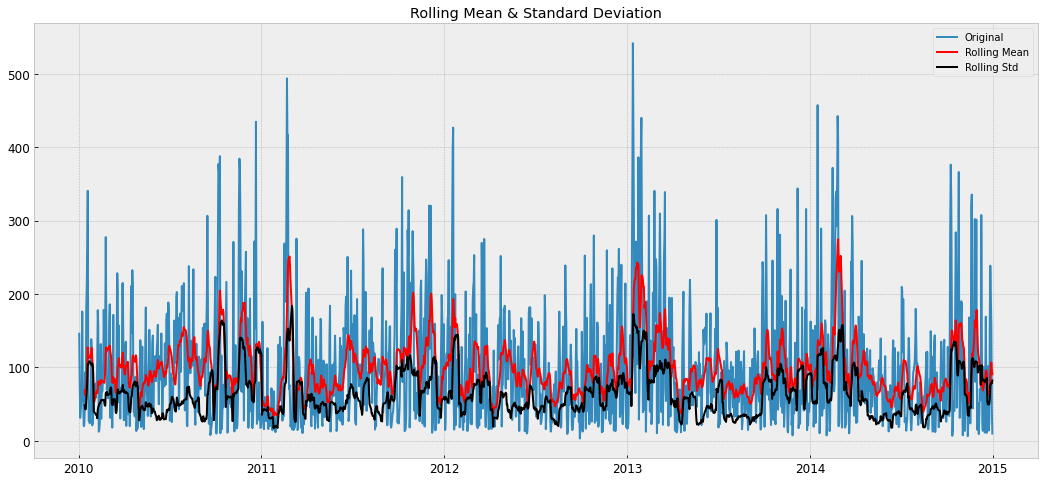

In [15]:
# Determing rolling statistics
rolmean = air_pollution.pollution_today.rolling(window=12).mean()
rolstd = air_pollution.pollution_today.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(air_pollution.pollution_today, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

We can see how our mean and standard deviation have a constant behaviour over the years, even if they change over the year this behaviour is then repeated next year. This proves us again a stationary series

### Augmented Dickey-Fuller test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
Below is an example of calculating the Augmented Dickey-Fuller test on the Daily Female Births dataset. The statsmodels library provides the adfuller() function that implements the test.


In [16]:
X = air_pollution.pollution_today.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.116719
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Here we also provide a method to quickly perform all the previous methods into one single function call and a pretty graph :)

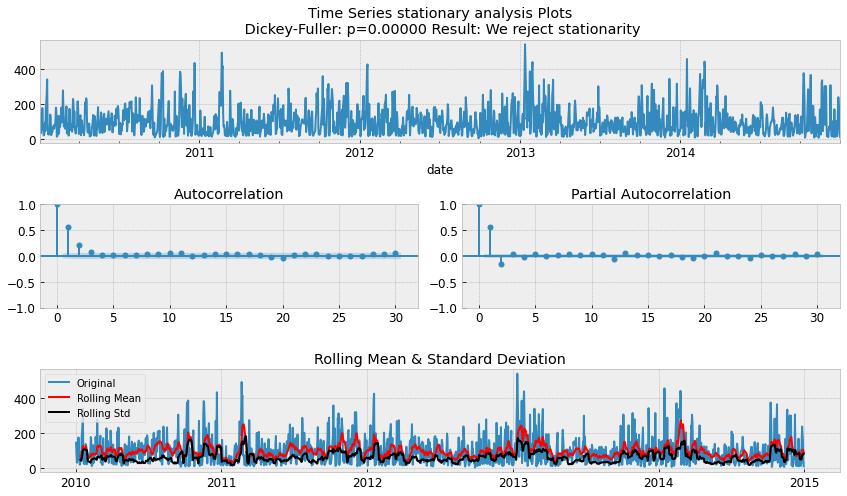

In [17]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = air_pollution.pollution_today.rolling(window=12).mean()
        rolstd = air_pollution.pollution_today.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(air_pollution.pollution_today, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(air_pollution.pollution_today, lags=30)

## Making Time Series Stationary

Okay we got lucky with this dataset and is already stationary, but what happens when this is not the case? We included a dummy dataset called `international_airline_passengers.csv` on the datasets folders which is not stationary and we will apply some methods in this section to transform it into a stationary series.

Text(0.5, 1.0, 'Original vs Windowed mean vs Windowed std')

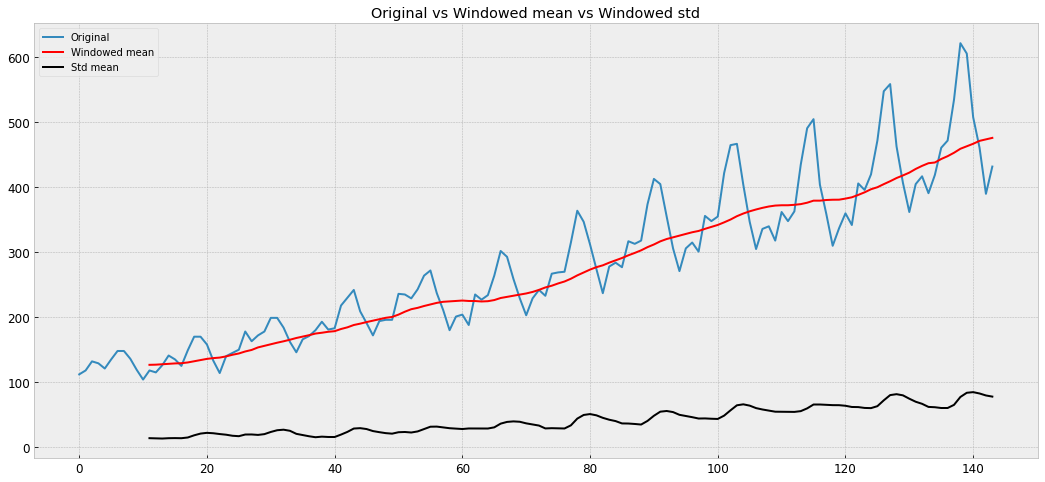

In [18]:
passengers = pd.read_csv("datasets/international_airline_passengers.csv")
passengers.passengers.plot(label='Original')
passengers.passengers.rolling(window=12).mean().plot(
    color='red', label='Windowed mean')
passengers.passengers.rolling(window=12).std().plot(
    color='black', label='Std mean')
plt.legend()
plt.title('Original vs Windowed mean vs Windowed std')

Lets run our stationary multitest function over this series

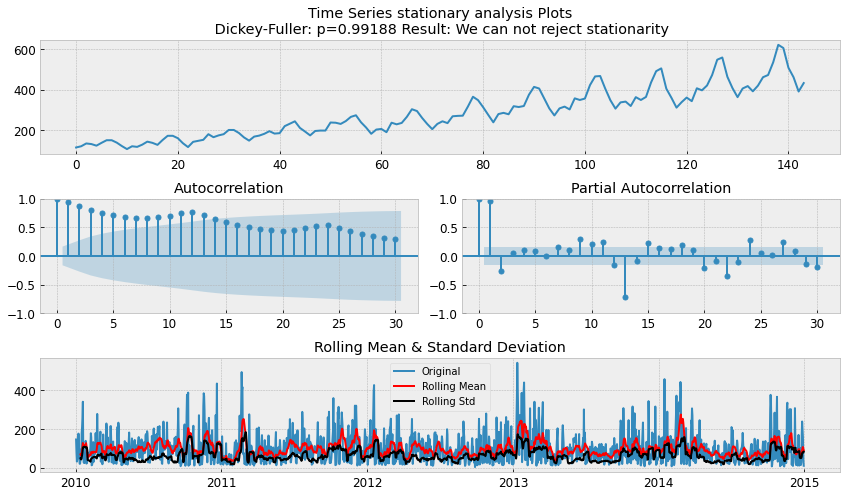

In [19]:
tsplot(passengers.passengers, lags=30)

With a p value of ~1 and high correlation values over time distant samples (showing a clear seasonality shape) we need to apply some methods to make the series stationary.

Coming back to the stationary definition, what makes our current series non stationary?

**Trend** - The mean for our series is not constant, it increases over time and

**Seasonality** - The values of our series vary over time with an specific pattern that repeats over time, this is called seasonalities (spike of people flying on the 24th of December)

We now present some methods to remove or smotth this trend and seasonality components

### Difference transform

Applying a difference transform to a time series could help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

`difference(t) = observation(t) - observation(t-1)`

Taking the difference between consecutive observations would be a lag-1 difference, we can tweek this lag value to fit our series.

We can also apply differencing transforms consecutively in the same series if the temporal effect hasnt been removed yet. This is called multiple order difference transform

In [20]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset = diff
    return diff

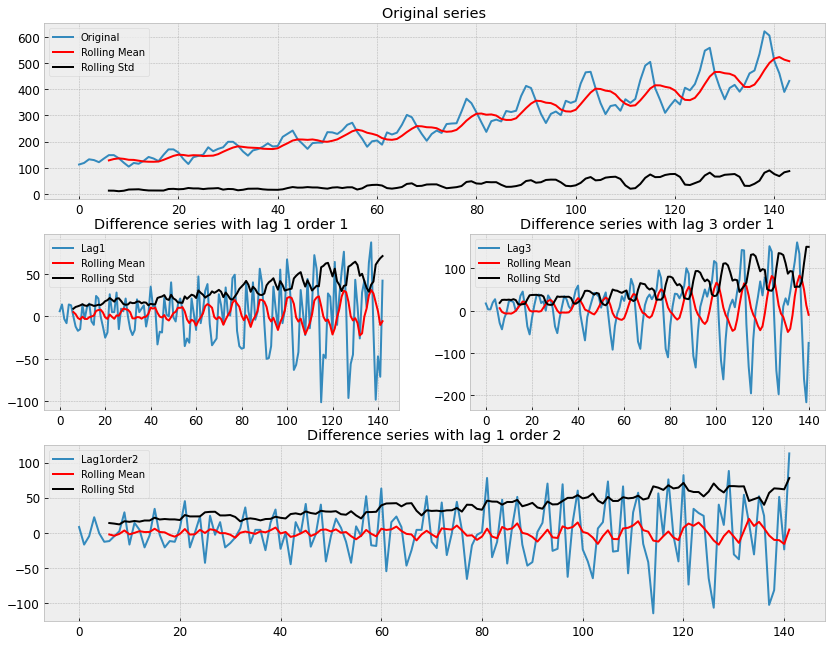

In [21]:
lag1series = pd.Series(difference(passengers.passengers, interval=1, order=1))
lag3series = pd.Series(difference(passengers.passengers, interval=3, order=1))
lag1order2series = pd.Series(difference(
    passengers.passengers, interval=1, order=2))

fig = plt.figure(figsize=(14, 11))
layout = (3, 2)
original = plt.subplot2grid(layout, (0, 0), colspan=2)
lag1 = plt.subplot2grid(layout, (1, 0))
lag3 = plt.subplot2grid(layout, (1, 1))
lag1order2 = plt.subplot2grid(layout, (2, 0), colspan=2)

original.set_title('Original series')
original.plot(passengers.passengers, label='Original')
original.plot(passengers.passengers.rolling(
    7).mean(), color='red', label='Rolling Mean')
original.plot(passengers.passengers.rolling(7).std(),
              color='black', label='Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label="Lag1")
lag1.plot(lag1series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(7).std(), color='black', label='Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label="Lag3")
lag3.plot(lag3series.rolling(7).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(7).std(), color='black', label='Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label="Lag1order2")
lag1order2.plot(lag1order2series.rolling(7).mean(),
                color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(7).std(),
                color='black', label='Rolling Std')
lag1order2.legend(loc='best')

We can see how 1 order differencing doesnt really remove stationary but once we go with a order 2 difference it looks closer to a stationary series

### Log scale transformation

Applying a log scale transform to a time series could also  help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

`LogScaleTransform(t)= Log(t)`

Text(0.5, 1.0, 'Log scale transformation into original series')

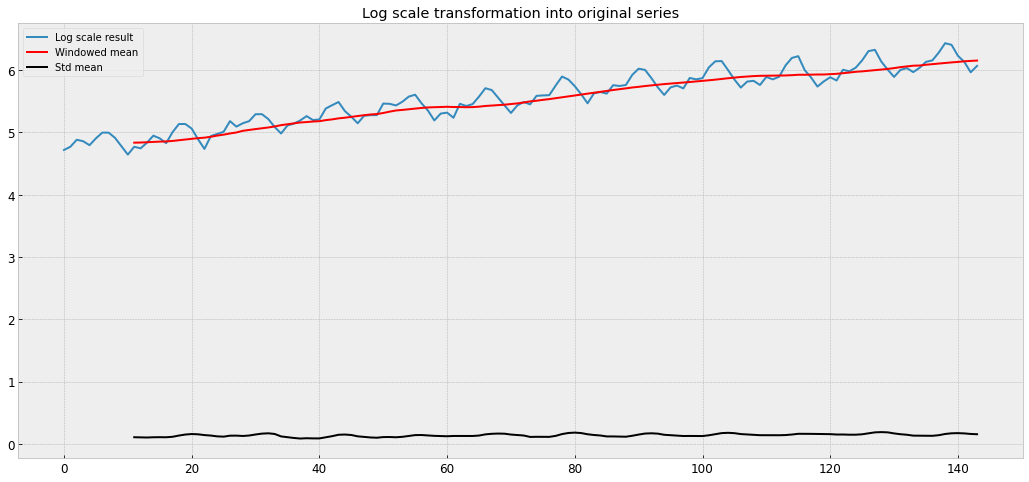

In [22]:
ts_log = np.log(passengers.passengers)
ts_log.plot(label='Log scale result')
ts_log.rolling(window=12).mean().plot(color='red', label='Windowed mean')
ts_log.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Log scale transformation into original series')

In [ ]:
# COmment results

### Smoothing

We have seen the moving mean as a measure to check stationarity, we can also apply windows to our series to remove seasonality.

With smotthing we will take rolling averages over periods of time. Is a bit tricky to choose the best windows. MORE ON THIS IN NEXT SECTION WITH AUTO WINDOWS

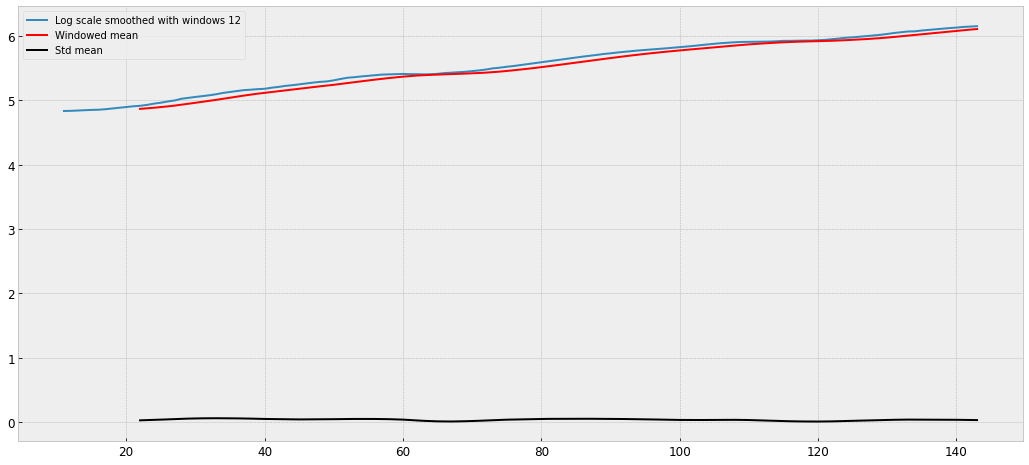

In [23]:
avg = pd.Series(ts_log).rolling(12).mean()
plt.plot(avg, label='Log scale smoothed with windows 12')
avg.rolling(window=12).mean().plot(color='red', label='Windowed mean')
avg.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()

We can combine it with our previous log scale and apply differencing

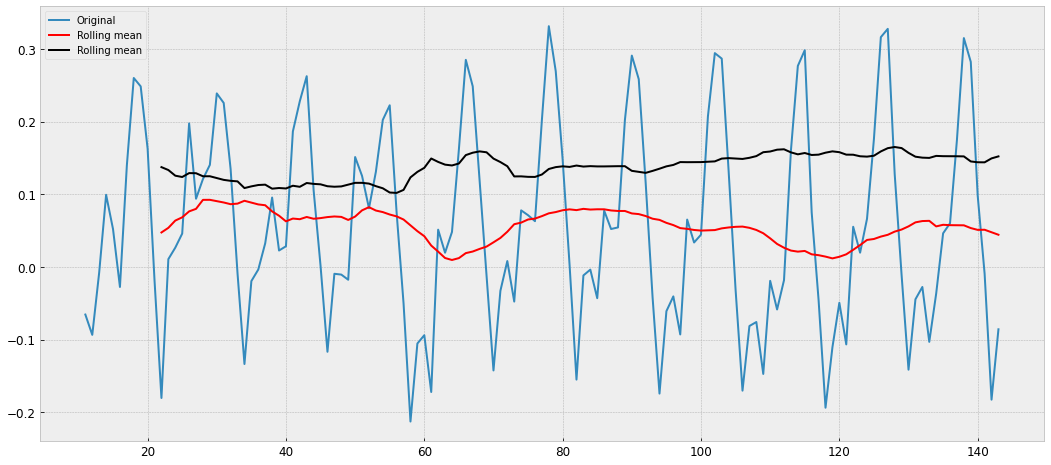

In [24]:
ts_log_moving_avg_diff = ts_log - avg

ts_log_moving_avg_diff.plot(label='Original')
ts_log_moving_avg_diff.rolling(12).mean().plot(
    color='red', label="Rolling mean")
ts_log_moving_avg_diff.rolling(12).std().plot(
    color='black', label="Rolling mean")
plt.legend(loc='best')